# Visualizing and Forecasting Apple Stock Prices
## Testing FB Prophet
### lightning talk Pythology Sept 22, 2017
#### AJ Rader, @indyrader, andrew.rader@gmail.com


In [1]:
import pandas as pd
from pandas_datareader import data, wb  # Package and modules for importing data; this code may change depending on pandas version
import datetime
 
# We will look at stock prices starting on January 1, 2016
start = datetime.datetime(2016,1,1)
end = datetime.date.today()
 
# Let's get Apple stock data; Apple's ticker symbol is AAPL
# First argument is the series we want, second is the source ("yahoo" for Yahoo! Finance), third is the start date, fourth is the end date
apple = data.DataReader("AAPL", "yahoo", start, end)
 
type(apple)

pandas.core.frame.DataFrame

In [2]:
apple.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,102.610001,105.370003,102.000000,105.349998,101.790649,67649400
2016-01-05,105.750000,105.849998,102.410004,102.709999,99.239845,55791000
2016-01-06,100.559998,102.370003,99.870003,100.699997,97.297760,68457400
2016-01-07,98.680000,100.129997,96.430000,96.449997,93.191338,81094400
2016-01-08,98.550003,99.110001,96.760002,96.959999,93.684120,70798000


# Visualizing the data

Populating the interactive namespace from numpy and matplotlib


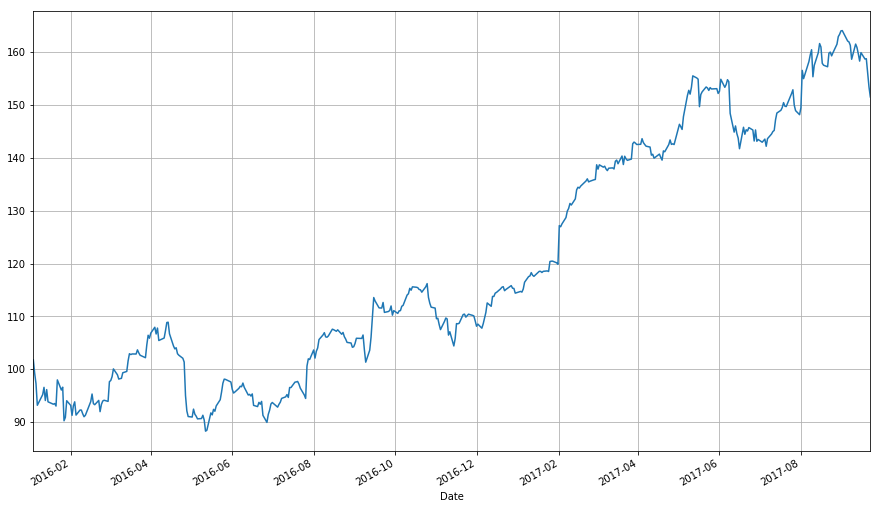

In [3]:
import matplotlib.pyplot as plt   # Import matplotlib
# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline
# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
 
apple["Adj Close"].plot(grid = True) # Plot the adjusted close

## pull some more stock data

In [5]:
microsoft = data.DataReader("MSFT", "yahoo", start, end)
google = data.DataReader("GOOG", "yahoo", start, end)
facebook = data.DataReader("FB","yahoo",start,end)
# Below I create a DataFrame consisting of the adjusted closing price of these stocks, first by making a list of these objects and using the join method
stocks = pd.DataFrame({"AAPL": apple["Adj Close"],
                      "MSFT": microsoft["Adj Close"],
                      "GOOG": google["Adj Close"]})
                      #"FB": facebook["Adj Close"]})
 
stocks.head()

RemoteDataError: Unable to read URL: https://query1.finance.yahoo.com/v7/finance/download/FB?period1=1451624400&period2=1506139199&interval=1d&events=history&crumb=yvt5SmpxT0%5Cu002F

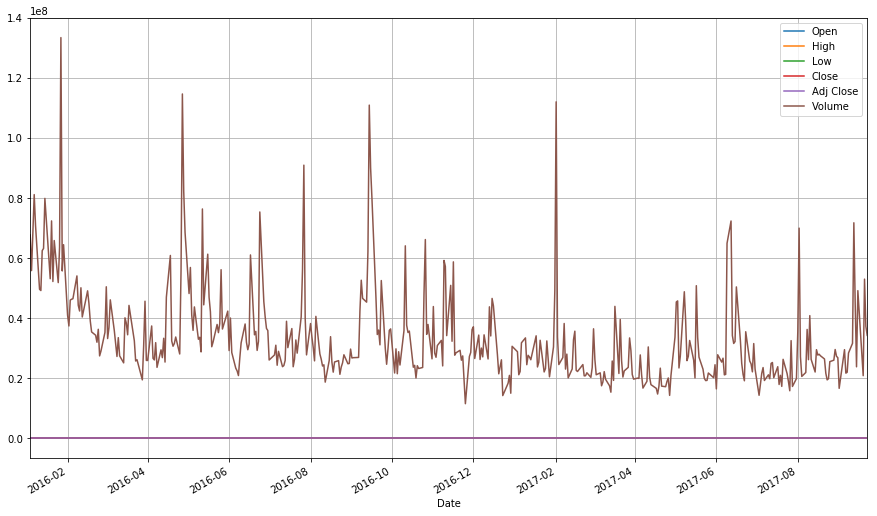

In [6]:
apple.plot(grid = True)

What’s wrong with this chart? While absolute price is important (pricy stocks are difficult to purchase, which affects not only their volatility but your ability to trade that stock), when trading, we are more concerned about the relative change of an asset rather than its absolute price. Google’s stocks are much more expensive than Apple’s or Microsoft’s, and this difference makes Apple’s and Microsoft’s stocks appear much less volatile than they truly are.

One solution would be to use two different scales when plotting the data; one scale will be used by Apple and Microsoft stocks, and the other by Google.

In [ ]:
stocks.plot(secondary_y = ["AAPL", "MSFT","FB"], grid = True)

A “better” solution, though, would be to plot the information we actually want: the stock’s returns. This involves transforming the data into something more useful for our purposes. There are multiple transformations we could apply.

One transformation would be to consider the stock’s return since the beginning of the period of interest. In other words, we plot:

$\text{return}_{t,0} = \frac{\text{price}_t}{\text{price}_0} $

This will require transforming the data in the stocks object, which I do next.



In [7]:
# df.apply(arg) will apply the function arg to each column in df, and return a DataFrame with the result
# Recall that lambda x is an anonymous function accepting parameter x; in this case, x will be a pandas Series object
stock_return = apple.apply(lambda x: x / x[0])
stock_return.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2016-01-05,1.030601,1.004555,1.004020,0.974941,0.974941,0.824708
2016-01-06,0.980021,0.971529,0.979118,0.955861,0.955861,1.011944
2016-01-07,0.961700,0.950270,0.945392,0.915520,0.915520,1.198745
2016-01-08,0.960433,0.940590,0.948627,0.920361,0.920361,1.046543


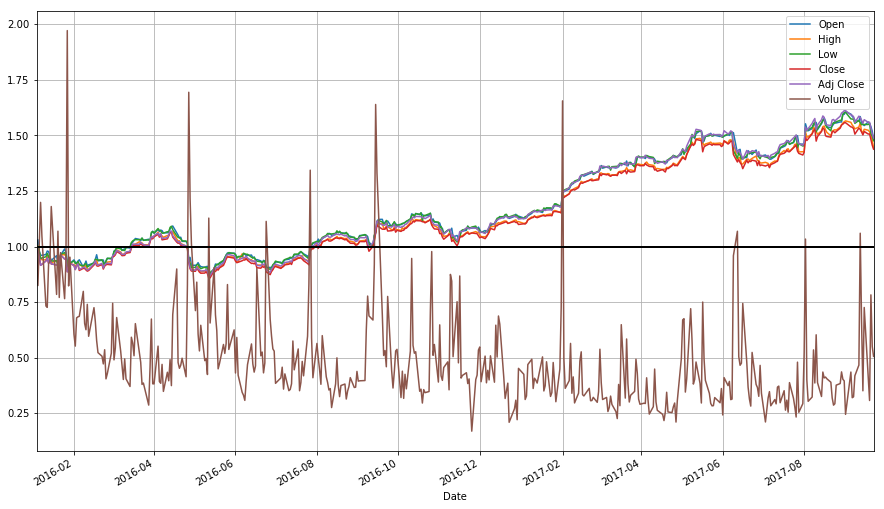

In [8]:
stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)


This is a much more useful plot. We can now see how profitable each stock was since the beginning of the period. Furthermore, we see that these stocks are highly correlated; they generally move in the same direction, a fact that was difficult to see in the other charts.

Alternatively, we could plot the change of each stock per day. One way to do so would be to plot the percentage increase of a stock when comparing day $t$ to day $t + 1$, with the formula:

$\text{growth}_t = \frac{\text{price}_{t + 1} - \text{price}_t}{\text{price}_t}$ 

But change could be thought of differently as:

$\text{increase}_t = \frac{\text{price}_{t} - \text{price}_{t-1}}{\text{price}_t} $

These formulas are not the same and can lead to differing conclusions, but there is another way to model the growth of a stock: with log differences.

$\text{change}_t = \log(\text{price}_{t}) - \log(\text{price}_{t - 1}) $

(Here, $\log$ is the natural log, and our definition does not depend as strongly on whether we use $\log(\text{price}_{t}) - \log(\text{price}_{t - 1})$ or $\log(\text{price}_{t+1}) - \log(\text{price}_{t})$.) The advantage of using log differences is that this difference can be interpreted as the percentage change in a stock but does not depend on the denominator of a fraction.

We can obtain and plot the log differences of the data in stocks as follows:

In [10]:
import numpy as np
 
stock_change = apple.apply(lambda x: np.log(x) - np.log(x.shift(1))) # shift moves dates back by 1.
stock_change.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,0.030142,0.004545,0.004012,-0.025379,-0.025379,-0.192726
2016-01-06,-0.050323,-0.033429,-0.025115,-0.019764,-0.019764,0.204599
2016-01-07,-0.018872,-0.022124,-0.035052,-0.043121,-0.043121,0.169402
2016-01-08,-0.001318,-0.010239,0.003416,0.005274,0.005274,-0.135783


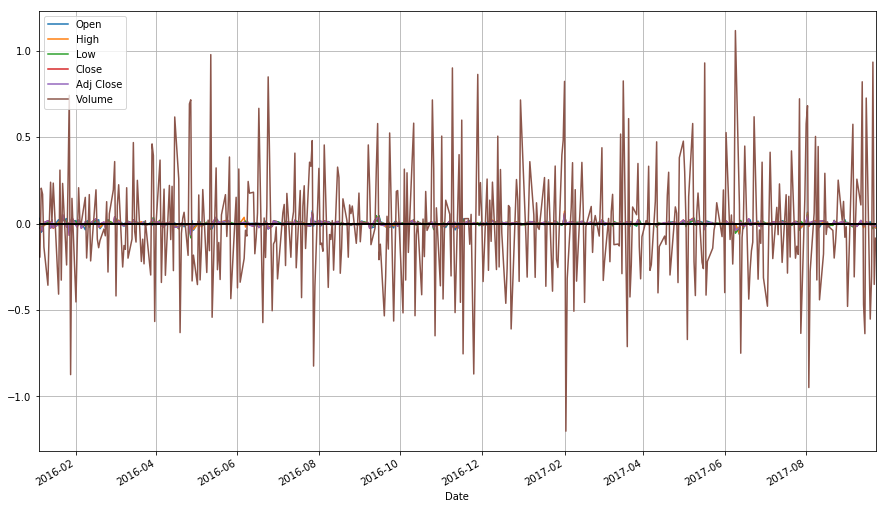

In [11]:
stock_change.plot(grid = True).axhline(y = 0, color = "black", lw = 2)


Which transformation do you prefer? Looking at returns since the beginning of the period make the overall trend of the securities in question much more apparent. Changes between days, though, are what more advanced methods actually consider when modelling the behavior of a stock. so they should not be ignored.

Moving Averages
Charts are very useful. In fact, some traders base their strategies almost entirely off charts (these are the “technicians”, since trading strategies based off finding patterns in charts is a part of the trading doctrine known as technical analysis). Let’s now consider how we can find trends in stocks.

A q-day moving average is, for a series x_t and a point in time t, the average of the past $q$ days: that is, if $MA^q_t$ denotes a moving average process, then:

$MA^q_t = \frac{1}{q} \sum_{i = 0}^{q-1} x_{t - i}$ 

Moving averages smooth a series and helps identify trends. The larger $q$ is, the _less_ responsive a moving average process is to short-term fluctuations in the series $x_t$. The idea is that moving average processes help identify trends from “noise”. Fast moving averages have smaller $q$ and more closely follow the stock, while slow moving averages have larger $q$, resulting in them responding less to the fluctuations of the stock and being more stable.

pandas provides functionality for easily computing moving averages. I demonstrate its use by creating a 20-day (one month) moving average for the Apple data, and plotting it alongside the stock.

In [12]:
apple["20d"] = np.round(apple["Close"].rolling(window = 20, center = False).mean(), 2)
#pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-08-07',:], otherseries = "20d")


## try to forecast with FBprophet

A common business analytics task is trying to forecast the future based on known historical data. 
Forecasting is a complicated topic and relies on an analyst knowing the ins and outs of the domain as well as knowledge of relatively complex mathematical theories. Because the mathematical concepts can be complex, a lot of business forecasting approaches are “solved” with a little linear regression and “intuition.” More complex models would yield better results but are too difficult to implement.

Facebook recently open sourced a python and R library called prophet which seeks to automate the forecasting process in a more sophisticated but easily tune-able model. 

<quote>
It's not your traditional ARIMA-style time series model. It's closer in spirit to a  Bayesian-influenced generalized additive model, a regression of smooth terms. The model is resistant   to the effects of outliers, and supports data collected over an irregular time scale (ingliding presence of missing data) without the need for interpolation. The underlying calculation engine is Stan; the R and Python packages simply provide a convenient interface.  
</quote>

In [18]:
apple

,Open,High,Low,Close,Adj Close,Volume,20d
Date,,,,,,,
2016-01-04,102.610001,105.370003,102.000000,105.349998,101.790649,67649400,NaN
2016-01-05,105.750000,105.849998,102.410004,102.709999,99.239845,55791000,NaN
2016-01-06,100.559998,102.370003,99.870003,100.699997,97.297760,68457400,NaN
2016-01-07,98.680000,100.129997,96.430000,96.449997,93.191338,81094400,NaN
2016-01-08,98.550003,99.110001,96.760002,96.959999,93.684120,70798000,NaN
2016-01-11,98.970001,99.059998,97.339996,98.529999,95.201073,49568300,NaN
2016-01-12,100.550003,100.690002,98.839996,99.959999,96.582756,49154200,NaN
2016-01-13,100.320000,101.190002,97.300003,97.389999,94.099594,62439600,NaN
2016-01-14,97.959999,100.480003,95.739998,99.519997,96.157608,63170100,NaN


In [13]:
from fbprophet import Prophet

In [21]:
df = pd.DataFrame()
df['ds'] = stock_return.index
#df['y_orig']=daily_df.Pageviews.values
df['y']=apple['Close'].apply(lambda x: np.log(x)).values
df.tail()

,ds,y
430,2017-09-18,5.066827
431,2017-09-19,5.067205
432,2017-09-20,5.050305
433,2017-09-21,5.032984
434,2017-09-22,5.020652


In [ ]:
## default out of the box.

In [22]:
m0 = Prophet(yearly_seasonality=True)
m0.fit(df)
#n_add = 365 - len()
n_add = 100
print("adding {n} days to reach the end of 2017.".format(n=n_add))
future = m0.make_future_dataframe(periods=n_add) # generate frame going to end of 2017; 112 added on 9/11/2017
future.tail()

adding 100 days to reach the end of 2017.


,ds
530,2017-12-27
531,2017-12-28
532,2017-12-29
533,2017-12-30
534,2017-12-31


In [23]:
forecast = m0.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
530,2017-12-27,4.858286,4.596559,5.114252
531,2017-12-28,4.853031,4.597783,5.111709
532,2017-12-29,4.851583,4.585411,5.122379
533,2017-12-30,4.805697,4.535823,5.071579
534,2017-12-31,4.804091,4.527721,5.072188


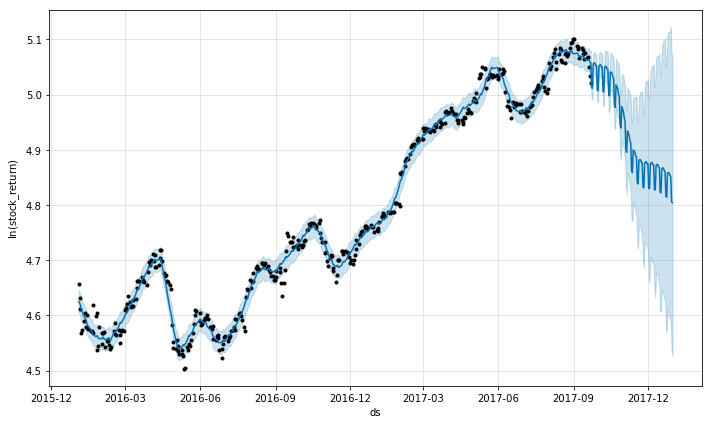

In [24]:
m0.plot(forecast, ylabel='$\ln($stock_return$)$');

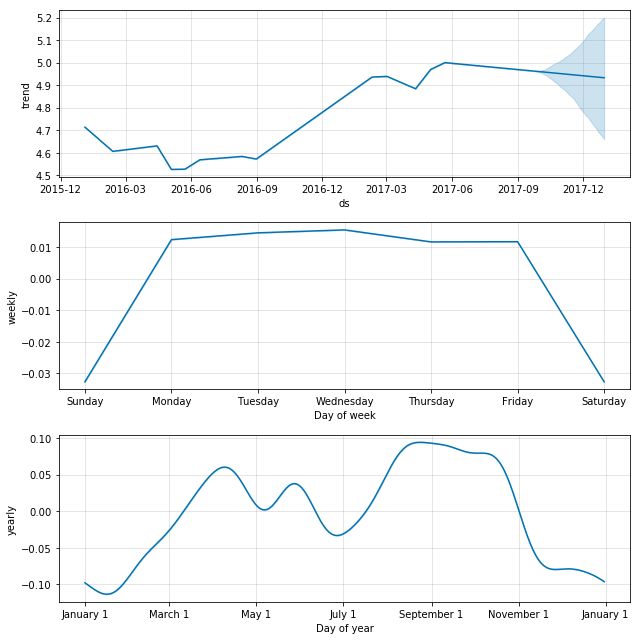

In [25]:
m0.plot_components(forecast);

# Implement 'shocks' based upon when there were new product releases by Apple.

In [26]:
releases = pd.DataFrame({
  'holiday': 'release',
  'ds': pd.to_datetime(['2016-03-31', '2016-04-19', '2016-09-16', '2016-10-27', '2016-10-28',
                        '2016-12-19', '2017-03-21','2017-03-24','2017-06-05', '2017-09-22']),
  'lower_window': 0,
  'upper_window': 5,
})
releases.head()

,ds,holiday,lower_window,upper_window
0,2016-03-31,release,0,5
1,2016-04-19,release,0,5
2,2016-09-16,release,0,5
3,2016-10-27,release,0,5
4,2016-10-28,release,0,5


Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


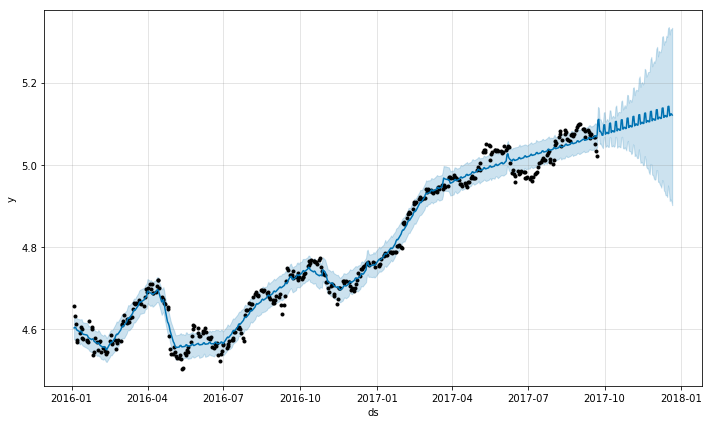

In [27]:
m2 = Prophet(holidays=releases).fit(df)
future2 = m2.make_future_dataframe(periods=90)
forecast2 = m2.predict(future2)
m2.plot(forecast2);

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
f_results = pd.merge(df[['ds','y']], forecast[['ds','yhat','yhat_lower','yhat_upper']], on='ds',how='left')
abs(f_results['yhat']-f_results['y']).plot()

In [ ]:
f_results = pd.merge(df[['ds','y']], forecast[['ds','yhat','yhat_lower','yhat_upper']], on='ds',how='left')
#abs(f_results['yhat']-f_results['y']).plot()

In [ ]:
print("Initial (seasonal) model has an MSE of {mse0} and MAE of {mae0}". format(mse0=mean_squared_error(f_results.yhat.values, f_results.y.values),
                                                                               mae0=mean_absolute_error(f_results.yhat.values,f_results.y.values)))

In [ ]:
f_results2 = pd.merge(df[['ds','y']], forecast2[['ds','yhat','yhat_lower','yhat_upper']], on='ds',how='left')
#abs(f_results['yhat']-f_results['y']).plot()

In [ ]:
print("2nd (seasonal+shocks) model has an MSE of {mse0} and MAE of {mae0}". format(mse0=mean_squared_error(f_results2.yhat.values, f_results2.y.values),
                                                                               mae0=mean_absolute_error(f_results2.yhat.values,f_results2.y.values)))

# Candlestick plot

In [ ]:
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc
 
def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()
 
pandas_candlestick_ohlc(apple)
